# Debug GestureNet OpenCL implement with PyOpenCL and PyTorch
Partial code are copied heavily from https://github.com/pytorch/vision/blob/master/torchvision/models/squeezenet.py  
SqueezeNet Paper:https://arxiv.org/abs/1602.07360  
SqueezeNet 1.1 model from https://github.com/DeepScale/SqueezeNet/tree/master/SqueezeNet_v1.1   
SqueezeNet 1.1 has 2.4x less computation and slightly fewer parameters than SqueezeNet 1.0, without sacrificing accuracy.


In [1]:
#some set up
import os
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from PIL import Image
import math
import time
from torchsummary import summary
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline

## Test top-1 accuracy on pytorch pre-trained SqueezeNet v1.1 

### Build GestureNet model for Accelerometer

In [2]:
class GestureAccelNet(nn.Module):
    def __init__(self, num_classes=2):
        super(GestureAccelNet, self).__init__()
        self.num_classes = num_classes
        self.features = nn.Sequential(
            nn.Linear(48,32,bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(32,20,bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(20,13,bias=True),
            nn.ReLU(inplace=True)
            )
        self.classifier = nn.Sequential(
            #nn.Dropout(p=0.5),
            nn.Linear(13,self.num_classes,bias=True),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.features(x)
        #print(x)
        x = self.classifier(x)
        #return x
        return x.view(x.size(0), self.num_classes)

In [3]:
model = GestureAccelNet()
print(model)

GestureAccelNet(
  (features): Sequential(
    (0): Linear(in_features=48, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=20, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=20, out_features=13, bias=True)
    (5): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=13, out_features=2, bias=True)
    (1): ReLU(inplace=True)
  )
)


In [4]:
summary(model,input_size=(1,48), batch_size=1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [1, 1, 32]           1,568
              ReLU-2                 [1, 1, 32]               0
            Linear-3                 [1, 1, 20]             660
              ReLU-4                 [1, 1, 20]               0
            Linear-5                 [1, 1, 13]             273
              ReLU-6                 [1, 1, 13]               0
            Linear-7                  [1, 1, 2]              28
              ReLU-8                  [1, 1, 2]               0
Total params: 2,529
Trainable params: 2,529
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


### Load  Dataset

In [5]:
classes = ['4_slow_swipe','9_circle']
y_train = [0,1]
x_train = np.zeros(shape=(1,48))
global datidx, labidx
datidx = 0
labidx = 0

In [6]:
from torch.utils.data import Dataset,DataLoader
class acceldataset(Dataset):
    def __init__(self, data, target):
        self.x_train = data
        self.y_train = target
    def __len__(self):
        return len(self.y_train)
    def __getitem__(self,idx):
        global datidx, labidx
        #print(y_train[idx])
        datidx+=1
        labidx+=1
        if datidx == 20:
            datidx = 0
        if labidx == 2:
            labidx = 0
        x_train=np.zeros(shape=(1,48))
        data=pd.read_csv('acceldataset/'+classes[labidx]+'/'+str(datidx)+'.csv')
        for i in range(0, 16):
            x_train[0][i*3] = data["wristX"][i]
            x_train[0][i*3+1] = data["wristY"][i]
            x_train[0][i*3+2] = data["wristZ"][i]
        #preprocess data
        #print(x_train)
        transform = transforms.Compose([
            transforms.ToTensor(),
            #transforms.Normalize(mean = [ 0.5, 0.5, 0.5 ],
             #                   std = [ 0.5, 0.5, 0.5 ]),
        ])
        self.x_train = transform(x_train)
        self.x_train = torch.reshape(self.x_train,(1,48))
        return self.x_train,self.y_train[labidx]

In [7]:
from sklearn.datasets import make_classification
data, target = make_classification(n_samples=1000)

In [8]:
dataset = acceldataset(data,target)
valdataset = acceldataset(data, target)
len(dataset)

1000

In [9]:
train_loader = DataLoader(dataset=dataset, batch_size=200, shuffle=True)
validate_loader = DataLoader(dataset=valdataset, batch_size=200, shuffle=True)

### Training Neural Network

In [10]:
train_losses = []
accuracylist = []
# Training  Model
def train_model(model, criterion, optimizer, num_epochs=25):
   since = time.time()

   for epoch in range(num_epochs):
       print('Epoch {}/{}'.format(epoch, num_epochs - 1))
       print('-' * 10)

       #set model to trainable
       train_loss = 0
       correct = 0
       # Iterate over data.
       for features, labels in train_loader:
           # Forward Pass
           #print(features.shape)
           output = model(features.float())
           loss = criterion(output, labels.long())
           optimizer.zero_grad() # clear previous gradients
           loss.backward() # backward pass
           optimizer.step()
           train_loss += loss.item()
           #print(np.argmax(output.detach().numpy(),axis=1))
           #print(labels.detach().numpy())
           correct += (np.argmax(output.detach().numpy(),axis=1) == labels.detach().numpy()).sum()
           print('{} Loss: {:.4f}'.format(
               'train', train_loss))
           train_losses.append(loss.item())
       accuracy = 100 * correct / len(dataset)
       accuracylist.append(accuracy)
   time_elapsed = time.time() - since
   print('Training complete in {:.0f}m {:.0f}s'.format(
       time_elapsed // 60, time_elapsed % 60))

   return model

In [11]:
validate_losses = []
def validate_model(model, num_epochs=25):
    since = time.time()
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Evaluate
        # model.eval()
        #Initialize
        correct = 0
        # Iterate over data.
        for features, labels in validate_loader:
            output = model(features.float())
            correct += (np.argmax(output.detach().numpy(),axis=1) == labels.detach().numpy()).sum()/len(dataset) *100
        validate_losses.append(correct)
        print('{} Acc: {:.4f}'.format(
            'Validate', correct))

In [12]:
# Define Hyper Parameters
criterion = torch.nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
loss_func = torch.nn.NLLLoss

In [13]:
train_model(model, criterion, optimizer_ft, num_epochs=25)

Epoch 0/24
----------
train Loss: 37.9832
train Loss: 40.6461
train Loss: 41.3393
train Loss: 42.0324
train Loss: 42.7256
Epoch 1/24
----------
train Loss: 0.6931
train Loss: 1.3863
train Loss: 2.0794
train Loss: 2.7726
train Loss: 3.4657
Epoch 2/24
----------
train Loss: 0.6931
train Loss: 1.3863
train Loss: 2.0794
train Loss: 2.7726
train Loss: 3.4657
Epoch 3/24
----------
train Loss: 0.6931
train Loss: 1.3863
train Loss: 2.0794
train Loss: 2.7726
train Loss: 3.4657
Epoch 4/24
----------
train Loss: 0.6931
train Loss: 1.3863
train Loss: 2.0794
train Loss: 2.7726
train Loss: 3.4657
Epoch 5/24
----------
train Loss: 0.6931
train Loss: 1.3863
train Loss: 2.0794
train Loss: 2.7726
train Loss: 3.4657
Epoch 6/24
----------
train Loss: 0.6931
train Loss: 1.3863
train Loss: 2.0794
train Loss: 2.7726
train Loss: 3.4657
Epoch 7/24
----------
train Loss: 0.6931
train Loss: 1.3863
train Loss: 2.0794
train Loss: 2.7726
train Loss: 3.4657
Epoch 8/24
----------
train Loss: 0.6931
train Loss: 1.3863

GestureAccelNet(
  (features): Sequential(
    (0): Linear(in_features=48, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=20, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=20, out_features=13, bias=True)
    (5): ReLU(inplace=True)
  )
  (classifier): Sequential(
    (0): Linear(in_features=13, out_features=2, bias=True)
    (1): ReLU(inplace=True)
  )
)

In [15]:
validate_model(model,num_epochs=25)

Epoch 0/24
----------
Validate Acc: 50.0000
Epoch 1/24
----------
Validate Acc: 50.0000
Epoch 2/24
----------
Validate Acc: 50.0000
Epoch 3/24
----------
Validate Acc: 50.0000
Epoch 4/24
----------
Validate Acc: 50.0000
Epoch 5/24
----------
Validate Acc: 50.0000
Epoch 6/24
----------
Validate Acc: 50.0000
Epoch 7/24
----------
Validate Acc: 50.0000
Epoch 8/24
----------
Validate Acc: 50.0000
Epoch 9/24
----------
Validate Acc: 50.0000
Epoch 10/24
----------
Validate Acc: 50.0000
Epoch 11/24
----------
Validate Acc: 50.0000
Epoch 12/24
----------
Validate Acc: 50.0000
Epoch 13/24
----------
Validate Acc: 50.0000
Epoch 14/24
----------
Validate Acc: 50.0000
Epoch 15/24
----------
Validate Acc: 50.0000
Epoch 16/24
----------
Validate Acc: 50.0000
Epoch 17/24
----------
Validate Acc: 50.0000
Epoch 18/24
----------
Validate Acc: 50.0000
Epoch 19/24
----------
Validate Acc: 50.0000
Epoch 20/24
----------
Validate Acc: 50.0000
Epoch 21/24
----------
Validate Acc: 50.0000
Epoch 22/24
--------

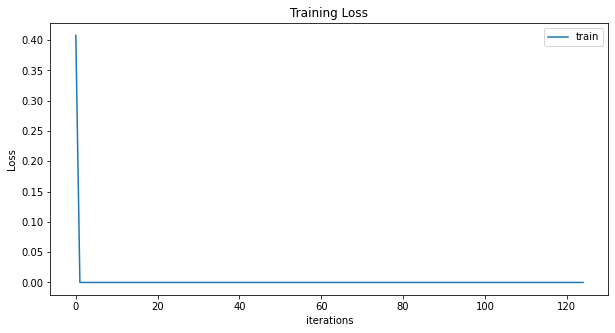

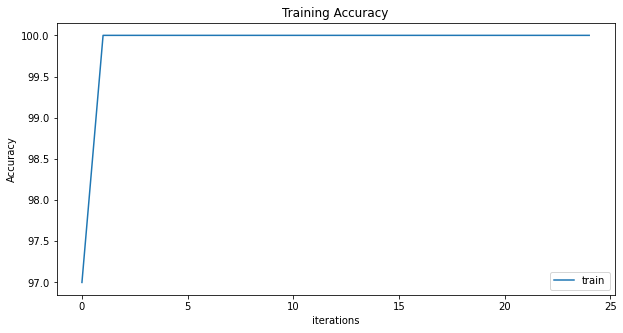

In [15]:
plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.figure(figsize=(10,5))
plt.title("Training Accuracy")
plt.plot(accuracylist,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

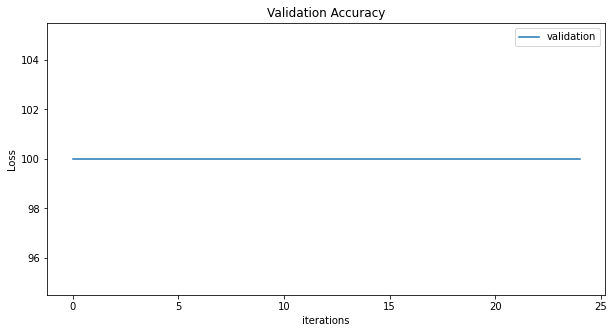

In [16]:
plt.figure(figsize=(10,5))
plt.title("Validation Accuracy")
plt.plot(validate_losses,label="validation")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [17]:
#torch.save(model.state_dict(), 'GestureAccelNet1.pth')

### Calculate top-1 accuracy of the pre-trained model

## Test Model in Pytorch if the OpenCL implement is correct
By comprare the result of OpenCL implement and PyTorch implement using a single image as input  
error = ((OpenCL_implement_class_socores - PyTorch_implement_class_socores) ^ 2).sum(element_wise)  
If the OpenCL implement is correct, error should be relativly small.

In [22]:
# load the test image
print(classes[1])
x_test=np.zeros(shape=(1,1,48))
data=pd.read_csv('acceldataset/'+classes[1]+'/'+str(1)+'.csv')
for i in range(0, 16):
    x_test[0][0][i*3] = data["wristX"][i]
    x_test[0][0][i*3+1] = data["wristY"][i]
    x_test[0][0][i*3+2] = data["wristZ"][i]
#preprocess data
transform = transforms.Compose([
    transforms.ToTensor()
])
x_test = transform(x_test[0])
x_test = torch.reshape(x_test,(1,1,48))
print(x_test.shape)

9_circle
torch.Size([1, 1, 48])


In [23]:
model.cpu()
y_test = model(x_test.float())
print(y_test)
_, predicted = torch.max(y_test.data, 1)
print(predicted)
print('the label index prediction of pytorch implement: '+classes[predicted])

tensor([[0., 0.]], grad_fn=<ViewBackward0>)
tensor([0])
the label index prediction of pytorch implement: 4_slow_swipe


### Load OpenCL implement
deviceinfo.py and partial pyopencl code are from Hands On OpenCL  
https://handsonopencl.github.io/

#### Step1: OpenCL preparation

In [17]:
# OpenCL setup
import pyopencl as cl
import deviceinfo

In [18]:
# Ask the user to select a platform/device on the CLI
context = cl.create_some_context()

# Print out device info
deviceinfo.output_device_info(context.devices[0])

# Create a command queue
queue = cl.CommandQueue(context)

Device is NVIDIA GeForce GTX 1650 TiGPU from NVIDIA Corporation with a max of 16 compute units


#### Step 2: import parameters from pytorch implement

In [19]:
params = model.state_dict()
for k,v in params.items():
    # print parameter name
    print(k,params[k].numpy().shape)
layer1_weight = params['features.0.weight'].numpy().reshape(-1)
layer1_bias = params['features.0.bias'].numpy()
layer2_weight = params['features.2.weight'].numpy().reshape(-1)
layer2_bias = params['features.2.bias'].numpy()
layer3_weight = params['features.4.weight'].numpy().reshape(-1)
layer3_bias = params['features.4.bias'].numpy()
classifier_weight = params['classifier.0.weight'].numpy().reshape(-1)
classifier_bias = params['classifier.0.bias'].numpy()

features.0.weight (32, 48)
features.0.bias (32,)
features.2.weight (20, 32)
features.2.bias (20,)
features.4.weight (13, 20)
features.4.bias (13,)
classifier.0.weight (2, 13)
classifier.0.bias (2,)


In [20]:
params['classifier.0.bias'].dtype
print(params['features.0.weight'].numpy()[0].shape)
print(params['features.0.bias'].shape)

(48,)
torch.Size([32])


Creat OpenCL memory object

In [24]:
h_sample = x_test.numpy().reshape(-1)
h_result_layer1 = np.empty(1 * 32).astype(np.float32)
h_result_layer2 = np.empty(1 * 20).astype(np.float32)
h_result_layer3 = np.empty(1 * 13).astype(np.float32)
h_result_classifier = np.empty(1 * len(classes)).astype(np.float32)

# device input buffer
d_sample = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=h_sample)

# device buffers 
d_layer1_weight = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=layer1_weight)
d_layer1_bias = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=layer1_bias)
d_layer2_weight = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=layer2_weight)
d_layer2_bias = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=layer2_bias)
d_layer3_weight = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=layer3_weight)
d_layer3_bias = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=layer3_bias)
d_classifier_weight = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=classifier_weight)
d_classifier_bias = cl.Buffer(context, cl.mem_flags.READ_ONLY | cl.mem_flags.COPY_HOST_PTR, hostbuf=classifier_bias)

d_result_layer1 = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, h_result_layer1.nbytes)
d_result_layer2 = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, h_result_layer2.nbytes)
d_result_layer3 = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, h_result_layer3.nbytes)
d_result_classifier = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, h_result_classifier.nbytes)

#### Step 3: create kernels
Create & build program

In [25]:
kernelSource = open("gesturenet.cl").read()
program = cl.Program(context, kernelSource).build()

Create kernels

In [26]:
conv3x3 = program.conv2d3x3
conv3x3.set_scalar_arg_dtypes([np.int32, np.int32, np.int32, np.int32, np.int32, np.int32, \
                               None, None, None, None])

maxpool = program.maxpool2d
maxpool.set_scalar_arg_dtypes([np.int32, np.int32, None, None])

conv1x1 = program.conv2d1x1
conv1x1.set_scalar_arg_dtypes([np.int32, np.int32, np.int32,\
                               None, None, None, None])

avgpool = program.avgpool2d
avgpool.set_scalar_arg_dtypes([np.int32,np.int32,None, None])

fc = program.fc
fc.set_scalar_arg_dtypes([np.int32,np.int32,None,None,None,None])

Run OpenCL implement  

In [27]:
rtime = time.time()
# First
#conv1x1(queue,(64,), None, 1, 16, 3, d_sample, d_layer1_weight ,d_layer1_bias, d_result_layer1)
fc(queue,(32,),None,1,48,d_sample,d_layer1_weight,d_layer1_bias,d_result_layer1)
# Second
#conv1x1(queue,(32,), None, 64, 16, 3, d_result_layer1, d_layer2_weight ,d_layer2_bias, d_result_layer2)
fc(queue,(20,),None,1,32,d_result_layer1,d_layer2_weight,d_layer2_bias,d_result_layer2)
# Third
#conv1x1(queue,(13,), None, 32, 16, 3, d_result_layer2, d_layer3_weight ,d_layer3_bias, d_result_layer3)
fc(queue,(13,),None,1,20,d_result_layer2,d_layer3_weight,d_layer3_bias,d_result_layer3)
# classifier
#conv1x1(queue,(len(classes),), None, 13, 16, 3, d_result_layer3, d_classifier_weight, d_classifier_bias, d_result_classifier)
fc(queue,(len(classes),),None,1,13,d_result_layer3,d_classifier_weight,d_classifier_bias,d_result_classifier)
# Wait for the commands to finish before reading back
queue.finish()
rtime = time.time() - rtime
print("The kernel ran in", rtime, "seconds")

The kernel ran in 0.011966228485107422 seconds


In [28]:
#copy result from gpu
cl.enqueue_copy(queue, h_result_classifier, d_result_classifier)
queue.finish()
label_opencl = np.argmax(h_result_classifier)
print('the label index prediction of OpenCL implement: %d' % label_opencl)

correct_result = y_test.data.numpy().reshape(-1)
error = ((correct_result - h_result_classifier) ** 2).sum()
print('OpenCL implement error: ', error)
cl.enqueue_copy(queue, h_result_layer1, d_result_layer1)
print(h_result_layer1.shape)
cl.enqueue_copy(queue, h_result_layer2, d_result_layer2)
print(h_result_layer2.shape)
cl.enqueue_copy(queue, h_result_layer3, d_result_layer3)
print(h_result_layer3.shape)
cl.enqueue_copy(queue, h_result_classifier, d_result_classifier)
print(h_result_classifier.shape)
print(y_test)
print(h_result_classifier)

the label index prediction of OpenCL implement: 0
OpenCL implement error:  0.0
(32,)
(20,)
(13,)
(2,)
tensor([[0., 0.]], grad_fn=<ViewBackward0>)
[0. 0.]
